In [49]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing import timeseries_dataset_from_array


In [50]:
# load the ED visits dataset that has been cleaned and preprocessed
df_event_log_dl = pd.read_csv('df_event_log_visits_for_ML.csv')

In [51]:
df_event_log_dl.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300775 entries, 0 to 300774
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             300775 non-null  object 
 1   SEX                             300775 non-null  int64  
 2   VISIT_ID                        300775 non-null  object 
 3   VISIT_AGE                       300775 non-null  float64
 4   CTAS                            300775 non-null  float64
 5   Case_Duration_Hours             300775 non-null  float64
 6   Is_Deceased                     300775 non-null  int64  
 7   Died_Before_Visit               300775 non-null  int64  
 8   Died_During_Visit               300775 non-null  int64  
 9   Died_After_Visit                300775 non-null  int64  
 10  Distance_to_Hospital            300775 non-null  float64
 11  Is_NL_Holiday                   300775 non-null  bool   
 12  Day_of_Week     

## Case Features:
Case features are attributes that are the same across all events within a single case (visit). 

In this case:

SID - Patient or session identifier (will be omitted for modeling as it doesn't add predictive value).

SEX - remains constant per case.

VISIT_ID - Case identifier - identifies the specific visit; constant for all events within that visit.

VISIT_AGE - Age of the patient, constant for the visit.

Is_Deceased - case attribute.

Distance_to_Hospital - constant for a given visit.

Is_NL_Holiday - constant for the visit.

Day_of_Week - constant for the visit.

Is_Weekend - constant for the visit.

Visit_Frequency - case-level feature.

Prior_LWBS - case-level feature.

Facility_IDs - case-level features.

Case_Duration_Hours - Duration of the case or visit, case-level feature.

TOTAL_PRECIPITATION - case-level features.

Imaging_Done - Whether imaging was done; specific to a case. 

Labs_Done - Whether lab tests were done; specific to a case. 

TIME_OF_THE_DAY_Ordinal - time of the day at the arrival of the patient, case-level feature.

Visit_Season_Ordinal - Season of the visit, specific to a case. 

## Event Features:
Event features are those that can vary from one event to another within the same visit:

CTAS - Triage score which can change if re-triaged during a visit.

ED_Business_Hourly - How busy the ED was, potentially varying hourly.

Activity_Encoded - varies by activity occurring during the visit. 

Is_LWBS - Indicates if the patient left without being seen, which is 
an outcome or event-specific feature.

Activity_Duration - Duration of specific activities within a visit.

Disposition_Frequency - Frequency of specific dispositions within the case, which could potentially vary as events unfold.

In [52]:


# Dictionary to rename the columns
rename_dict = {
    'SID': 'case:SID',
    'SEX': 'case:SEX',
    'VISIT_ID': 'case:VISIT_ID',
    'VISIT_AGE': 'case:VISIT_AGE',
    'Case_Duration_Hours': 'case:Case_Duration_Hours',
    'Is_Deceased': 'case:Is_Deceased',
    'Distance_to_Hospital': 'case:Distance_to_Hospital',
    'Is_NL_Holiday': 'case:Is_NL_Holiday',
    'Day_of_Week': 'case:Day_of_Week',
    'Is_Weekend': 'case:Is_Weekend',
    'Visit_Frequency': 'case:Visit_Frequency',
    'Prior_LWBS': 'case:Prior_LWBS',
    'FACILITY_ID_BUR': 'case:FACILITY_ID_BUR',
    'FACILITY_ID_CGH': 'case:FACILITY_ID_CGH',
    'FACILITY_ID_GBC': 'case:FACILITY_ID_GBC',
    'FACILITY_ID_HSC': 'case:FACILITY_ID_HSC',
    'FACILITY_ID_SCM': 'case:FACILITY_ID_SCM',
    'TIME_OF_THE_DAY_Ordinal': 'case:TIME_OF_THE_DAY_Ordinal',
    'Visit_Season_Ordinal': 'case:Visit_Season_Ordinal',
    'CTAS': 'event:CTAS',
    'ED_Business_Hourly': 'event:ED_Business_Hourly',
    'Is_LWBS': 'event:Is_LWBS',
    'Activity_Duration': 'event:Activity_Duration',
    'Disposition_Frequency': 'event:Disposition_Frequency',
    'Died_Before_Visit': 'case:Died_Before_Visit',
    'Died_During_Visit': 'case:Died_During_Visit',
    'Died_After_Visit': 'case:Died_After_Visit',
    'Num_Imaging_Tests': 'case:Num_Imaging_Tests',
    'Num_Lab_Tests': 'case:Num_Lab_Tests',
    'First_Imaging_Test_Encoded': 'case:First_Imaging_Test_Encoded',
    'First_Lab_Test_Encoded': 'case:First_Lab_Test_Encoded',
    'Activity_Admitting patient': 'event:Activity_Admitting patient',
    'Activity_Assessment': 'event:Activity_Assessment',
    'Activity_Making admit decision': 'event:Activity_Making admit decision',
    'Activity_Patient departed': 'event:Activity_Patient departed',
    'Activity_Patient discharge': 'event:Activity_Patient discharge',
    'Activity_Providing service': 'event:Activity_Providing service',
    'Activity_Triage': 'event:Activity_Triage'
}

# Renaming the columns
df_event_log_dl.rename(columns=rename_dict, inplace=True)

# Display the renamed columns
print(df_event_log_dl.columns)


Index(['case:SID', 'case:SEX', 'case:VISIT_ID', 'case:VISIT_AGE', 'event:CTAS',
       'case:Case_Duration_Hours', 'case:Is_Deceased',
       'case:Died_Before_Visit', 'case:Died_During_Visit',
       'case:Died_After_Visit', 'case:Distance_to_Hospital',
       'case:Is_NL_Holiday', 'case:Day_of_Week', 'case:Is_Weekend',
       'case:Visit_Frequency', 'event:Is_LWBS', 'case:Prior_LWBS',
       'event:ED_Business_Hourly', 'case:Num_Imaging_Tests',
       'case:Num_Lab_Tests', 'case:First_Imaging_Test_Encoded',
       'case:First_Lab_Test_Encoded', 'case:FACILITY_ID_BUR',
       'case:FACILITY_ID_CGH', 'case:FACILITY_ID_GBC', 'case:FACILITY_ID_HSC',
       'case:FACILITY_ID_SCM', 'event:Activity_Admitting patient',
       'event:Activity_Assessment', 'event:Activity_Making admit decision',
       'event:Activity_Patient departed', 'event:Activity_Patient discharge',
       'event:Activity_Providing service', 'event:Activity_Triage',
       'case:TIME_OF_THE_DAY_Ordinal', 'case:Visit_Seas

In [53]:
# Dropping the 'SID' column from the DataFrame
df_event_log_dl = df_event_log_dl.drop('case:SID', axis=1)

df_event_log_dl.head()

,case:SEX,case:VISIT_ID,case:VISIT_AGE,event:CTAS,case:Case_Duration_Hours,case:Is_Deceased,case:Died_Before_Visit,case:Died_During_Visit,case:Died_After_Visit,case:Distance_to_Hospital,...,event:Activity_Assessment,event:Activity_Making admit decision,event:Activity_Patient departed,event:Activity_Patient discharge,event:Activity_Providing service,event:Activity_Triage,case:TIME_OF_THE_DAY_Ordinal,case:Visit_Season_Ordinal,event:Activity_Duration,event:Disposition_Frequency
0,1,VISIT2354278,26.166667,3.0,1.366667,0,0,0,0,55.947701,...,False,False,False,False,False,True,2.0,1.0,0.000000,1.0
1,1,VISIT2354278,26.166667,3.0,1.366667,0,0,0,0,55.947701,...,False,False,False,False,True,False,2.0,1.0,0.016667,1.0
2,1,VISIT2354278,26.166667,3.0,1.366667,0,0,0,0,55.947701,...,False,False,True,False,False,False,2.0,1.0,1.350000,1.0
3,1,VISIT2233914,22.000000,4.0,3.166667,0,0,0,0,243.167901,...,False,False,False,False,False,True,1.0,1.0,0.000000,1.0
4,1,VISIT2233914,22.000000,4.0,3.166667,0,0,0,0,243.167901,...,False,False,False,False,True,False,1.0,1.0,0.183333,1.0


In [54]:
df_event_log_dl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300775 entries, 0 to 300774
Data columns (total 37 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   case:SEX                              300775 non-null  int64  
 1   case:VISIT_ID                         300775 non-null  object 
 2   case:VISIT_AGE                        300775 non-null  float64
 3   event:CTAS                            300775 non-null  float64
 4   case:Case_Duration_Hours              300775 non-null  float64
 5   case:Is_Deceased                      300775 non-null  int64  
 6   case:Died_Before_Visit                300775 non-null  int64  
 7   case:Died_During_Visit                300775 non-null  int64  
 8   case:Died_After_Visit                 300775 non-null  int64  
 9   case:Distance_to_Hospital             300775 non-null  float64
 10  case:Is_NL_Holiday                    300775 non-null  bool   
 11  

In [55]:
# Sort by VISIT_ID before grouping
df_event_log_dl_sorted = df_event_log_dl.sort_values(by='case:VISIT_ID')
grouped = df_event_log_dl_sorted.groupby('case:VISIT_ID')

# Display the first few entries from each group
grouped.head()


,case:SEX,case:VISIT_ID,case:VISIT_AGE,event:CTAS,case:Case_Duration_Hours,case:Is_Deceased,case:Died_Before_Visit,case:Died_During_Visit,case:Died_After_Visit,case:Distance_to_Hospital,...,event:Activity_Assessment,event:Activity_Making admit decision,event:Activity_Patient departed,event:Activity_Patient discharge,event:Activity_Providing service,event:Activity_Triage,case:TIME_OF_THE_DAY_Ordinal,case:Visit_Season_Ordinal,event:Activity_Duration,event:Disposition_Frequency
35374,1,VISIT2208402,62.750000,3.0,0.550000,0,0,0,0,22.233700,...,False,False,False,False,False,True,0.0,1.0,0.000000,0.714286
35375,1,VISIT2208402,62.750000,3.0,0.550000,0,0,0,0,22.233700,...,False,False,False,False,True,False,0.0,1.0,0.033333,0.714286
35376,1,VISIT2208402,62.750000,3.0,0.550000,0,0,0,0,22.233700,...,True,False,False,False,False,False,0.0,1.0,0.100000,0.714286
35377,1,VISIT2208402,62.750000,3.0,0.550000,0,0,0,0,22.233700,...,False,False,True,False,False,False,0.0,1.0,0.416667,0.714286
213202,0,VISIT2208404,23.166667,4.0,5.333333,0,0,0,0,0.429780,...,True,False,False,False,False,False,0.0,1.0,4.766667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258788,1,VISIT2377969,33.750000,4.0,2.750000,0,0,0,0,3.093499,...,False,False,False,False,False,True,2.0,1.0,0.000000,0.272727
148222,1,VISIT2377970,62.083333,3.0,8.233333,0,0,0,0,4.910799,...,False,False,False,False,True,False,2.0,1.0,0.116667,1.000000
148221,1,VISIT2377970,62.083333,3.0,8.233333,0,0,0,0,4.910799,...,False,False,False,False,False,True,2.0,1.0,0.000000,1.000000
148224,1,VISIT2377970,62.083333,3.0,8.233333,0,0,0,0,4.910799,...,False,False,True,False,False,False,2.0,1.0,0.150000,1.000000


In [43]:

sequences = []
sequence_length = 7  

import numpy as np

# Assume sequences is already defined as empty list
sequences = []
sequence_length = 7

for _, group in grouped:
    # Drop 'VISIT_ID' from the group, then convert to float
    group_features = group.drop(['event:Is_LWBS', 'case:VISIT_ID'], axis=1).astype(float)
    group_labels = group['event:Is_LWBS']
    
    # Padding if necessary
    num_missing = sequence_length - len(group)
    if num_missing > 0:
        # Padding features with zeros
        padding = np.zeros((num_missing, group_features.shape[1]))
        group_features = np.vstack((group_features, padding))
        # Padding labels with a neutral value 
        padded_labels = np.pad(group_labels, (0, num_missing), 'edge')
    elif num_missing < 0:
        group_features = group_features.iloc[:sequence_length]
        group_labels = group_labels.iloc[:sequence_length]



    # Add to sequences
    sequences.append((group_features, group_labels.iloc[-1]))

# Convert to array for further processing
uniform_sequences = np.array([np.array(feature) for feature, label in sequences], dtype=object)
labels = np.array([label for feature, label in sequences])




In [59]:
sequences = []
sequence_length = 7

for _, group in grouped:
    # Drop 'VISIT_ID' from the group, then convert to float
    group_features = group.drop(['event:Is_LWBS', 'case:VISIT_ID'], axis=1).astype(float)
    group_labels = group['event:Is_LWBS']
    
    # Padding if necessary
    num_missing = sequence_length - len(group)
    if num_missing > 0:
        # Padding features with zeros at the beginning
        padding = np.zeros((num_missing, group_features.shape[1]))
        group_features = np.vstack((padding, group_features))
        # Padding labels with a neutral value at the beginning
        padded_labels = np.pad(group_labels, (num_missing, 0), 'edge')
    elif num_missing < 0:
        group_features = group_features.iloc[:sequence_length]
        group_labels = group_labels.iloc[:sequence_length]
        padded_labels = group_labels.values
    else:
        padded_labels = group_labels.values

    # Add to sequences
    sequences.append((group_features, padded_labels[-1]))

# Convert to array for further processing
uniform_sequences = np.array([np.array(feature) for feature, label in sequences], dtype=object) 



In [60]:
uniform_sequences[0]

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [1.0, 62.75, 3.0, 0.55, 0.0, 0.0, 0.0, 0.0, 22.233700149895167,
        0.0, 4.0, 0.0, 4.0, 0.0, 11.0, 1.0, 0.0, 64.0, 85.0, 0.0, 1.0,
        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,
        0.7142857142857143],
       [1.0, 62.75, 3.0, 0.55, 0.0, 0.0, 0.0, 0.0, 22.233700149895167,
        0.0, 4.0, 0.0, 4.0, 0.0, 11.0, 1.0, 0.0, 64.0, 85.0, 0.0, 1.0,
        0.0, 0

In [61]:
# training, validation, and testing splits
train_idx = int(.6 * len(sequences))
val_idx = int(.8 * len(sequences))

# Splitting sequences and labels
train_sequences = sequences[:train_idx]
val_sequences = sequences[train_idx:val_idx]
test_sequences = sequences[val_idx:]

# Extracting features and labels from sequences
train_features = np.array([seq[0] for seq in train_sequences])
val_features = np.array([seq[0] for seq in val_sequences])
test_features = np.array([seq[0] for seq in test_sequences])

train_labels = np.array([seq[1] for seq in train_sequences])
val_labels = np.array([seq[1] for seq in val_sequences])
test_labels = np.array([seq[1] for seq in test_sequences])


In [62]:
train_features[0]


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       

In [63]:
# Create TensorFlow datasets
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(32)


In [65]:
def inspect_single_sequence(dataset, num_batches=1):
    # Convert the dataset to a list of numpy arrays for inspection
    dataset_samples = list(dataset.as_numpy_iterator())

    for i in range(min(num_batches, len(dataset_samples))):
        batch_features, batch_labels = dataset_samples[i]

        # Inspect the first sequence in the batch
        inspected_features = batch_features[0]
        inspected_labels = batch_labels[0]

        print(f"Batch {i + 1} - Inspected Features:\n", inspected_features)
        print(f"Batch {i + 1} - Inspected Label:\n", inspected_labels)
        print("\n")

# Inspect sequences from training, validation, and test datasets
print("Training Dataset Inspection:")
inspect_single_sequence(train_dataset)

print("Validation Dataset Inspection:")
inspect_single_sequence(val_dataset)

print("Test Dataset Inspection:")
inspect_single_sequence(test_dataset)


Training Dataset Inspection:
Batch 1 - Inspected Features:
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, input_shape=(sequence_length, train_features.shape[2]), activation='relu'), 
    Dense(1, activation='sigmoid')
])




In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
1460/1460 [==============================] - 14s 8ms/step - loss: 0.1933 - accuracy: 0.9272 - val_loss: 0.1832 - val_accuracy: 0.8754
Epoch 2/10
1460/1460 [==============================] - 11s 8ms/step - loss: 0.1070 - accuracy: 0.9569 - val_loss: 0.1087 - val_accuracy: 0.9545
Epoch 3/10
1460/1460 [==============================] - 13s 9ms/step - loss: 0.0610 - accuracy: 0.9812 - val_loss: 0.0893 - val_accuracy: 0.9652
Epoch 4/10
1460/1460 [==============================] - 12s 8ms/step - loss: 0.0498 - accuracy: 0.9864 - val_loss: 0.0704 - val_accuracy: 0.9728
Epoch 5/10
1460/1460 [==============================] - 12s 8ms/step - loss: 0.0336 - accuracy: 0.9905 - val_loss: 0.0604 - val_accuracy: 0.9786
Epoch 6/10
1460/1460 [==============================] - 12s 8ms/step - loss: 0.0414 - accuracy: 0.9901 - val_loss: 0.0404 - val_accuracy: 0.9890
Epoch 7/10
1460/1460 [==============================] - 12s 8ms/step - loss: 0.0296 - accuracy: 0.9914 - val_loss: 0.0556 - val_ac

487/487 [==============================] - 2s 4ms/step
Confusion Matrix:
 [[13323   159]
 [   41  2049]]


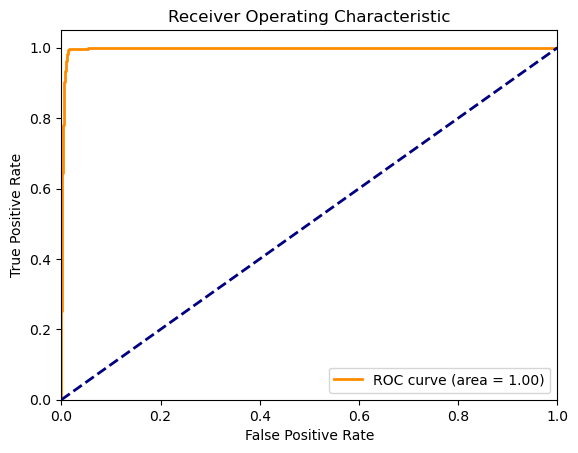

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Generate predictions
y_pred = model.predict(test_dataset).ravel()  # Flatten the predictions

# Converting probabilities to binary output based on a threshold
y_pred_bin = (y_pred > 0.5).astype('int')

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred_bin)
print("Confusion Matrix:\n", cm)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


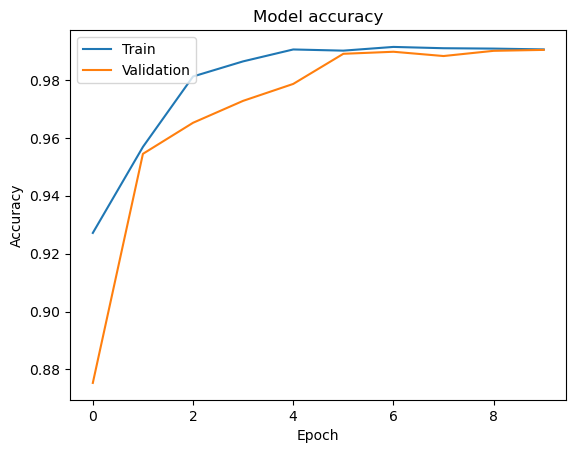

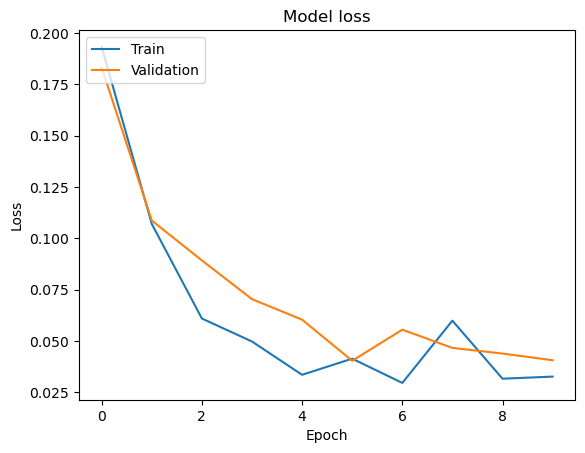

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


487/487 [==============================] - 2s 4ms/step - loss: 0.0390 - accuracy: 0.9872
Test Loss: 0.03900313004851341
Test Accuracy: 0.9871564507484436


In [17]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np


features = np.array([seq[0] for seq in sequences])  # feature sequences
labels = np.array([seq[1] for seq in sequences])    # Corresponding labels

# Define the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# This will be used to store scores or losses for each fold
fold_results = []


In [18]:
for train_index, test_index in tscv.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Create a new instance of the model 
    model = Sequential([
        LSTM(50, input_shape=(sequence_length, X_train.shape[2]), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

   


In [19]:
 # Fit the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

   

Epoch 1/10
2028/2028 [==============================] - 19s 8ms/step - loss: 0.1748 - accuracy: 0.9340 - val_loss: 0.0989 - val_accuracy: 0.9594
Epoch 2/10
2028/2028 [==============================] - 15s 8ms/step - loss: 0.0589 - accuracy: 0.9831 - val_loss: 0.0522 - val_accuracy: 0.9839
Epoch 3/10
2028/2028 [==============================] - 16s 8ms/step - loss: 0.0387 - accuracy: 0.9890 - val_loss: 0.0512 - val_accuracy: 0.9850
Epoch 4/10
2028/2028 [==============================] - 15s 8ms/step - loss: 0.0350 - accuracy: 0.9897 - val_loss: 0.0459 - val_accuracy: 0.9861
Epoch 5/10
2028/2028 [==============================] - 16s 8ms/step - loss: 0.0331 - accuracy: 0.9900 - val_loss: 0.0543 - val_accuracy: 0.9802
Epoch 6/10
2028/2028 [==============================] - 16s 8ms/step - loss: 0.0311 - accuracy: 0.9906 - val_loss: 0.0418 - val_accuracy: 0.9864
Epoch 7/10
2028/2028 [==============================] - 15s 7ms/step - loss: 0.0278 - accuracy: 0.9916 - val_loss: 0.0578 - val_ac

In [20]:
 # Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
fold_results.append(scores)




In [21]:
# After all folds are completed, you can calculate the average performance
average_performance = np.mean(fold_results, axis=0)
print(f"Average Performance across folds: {average_performance}")

Average Performance across folds: [0.04289136 0.98682183]


In [34]:
 # List of columns in the DataFrame
columns = list(df_event_log_dl.columns)

# Removing identifiers and the target variable from the feature names
feature_names = [col for col in columns if col not in ('SID', 'VISIT_ID', 'Is_LWBS')]
feature_names

['SEX',
 'VISIT_AGE',
 'CTAS',
 'Case_Duration_Hours',
 'Is_Deceased',
 'Died_Before_Visit',
 'Died_During_Visit',
 'Died_After_Visit',
 'Distance_to_Hospital',
 'Is_NL_Holiday',
 'Day_of_Week',
 'Is_Weekend',
 'Visit_Frequency',
 'Prior_LWBS',
 'ED_Business_Hourly',
 'Num_Imaging_Tests',
 'Num_Lab_Tests',
 'First_Imaging_Test_Encoded',
 'First_Lab_Test_Encoded',
 'FACILITY_ID_BUR',
 'FACILITY_ID_CGH',
 'FACILITY_ID_GBC',
 'FACILITY_ID_HSC',
 'FACILITY_ID_SCM',
 'Activity_Admitting patient',
 'Activity_Assessment',
 'Activity_Making admit decision',
 'Activity_Patient departed',
 'Activity_Patient discharge',
 'Activity_Providing service',
 'Activity_Triage',
 'TIME_OF_THE_DAY_Ordinal',
 'Visit_Season_Ordinal',
 'Activity_Duration',
 'Disposition_Frequency']

In [23]:
print("X_train shape:", X_train.shape)
print("Number of feature names:", len(feature_names))


X_train shape: (64884, 7, 35)
Number of feature names: 35


In [30]:
import shap
import numpy as np

# Flattening the training and test data for KernelExplainer
subsampleX = shap.sample(X_train.reshape(X_train.shape[0], -1), 100)  # Reshape and sample
subsampleX_test = shap.sample(X_test.reshape(X_test.shape[0], -1), 100)

def model_predict(data):
    # Reshape flattened data to the expected input shape (7, 35) just before prediction
    data_reshaped = data.reshape(-1, 7, 35)
    return model.predict(data_reshaped).flatten()  

# KernelExplainer
explainer = shap.KernelExplainer(model_predict, subsampleX, nsamples=50)
shap_values = explainer.shap_values(subsampleX_test)


4/4 [==============================] - 0s 4ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

7563/7563 [==============================] - 28s 4ms/step


In [39]:
print("Number of features in feature_names:", len(feature_names))
print("Number of features in SHAP values:", np.array(shap_values).shape[-1])  # Adjust depending on the shape of shap_values


Number of features in feature_names: 35
Number of features in SHAP values: 245


In [37]:
expanded_feature_names = []
for t in range(7):  # Assuming 7 time steps
    expanded_feature_names.extend([f"{name}_T{t+1}" for name in feature_names])

# Now expanded_feature_names should have 245 elements
print("Expanded Feature Names Count:", len(expanded_feature_names))


Expanded Feature Names Count: 245


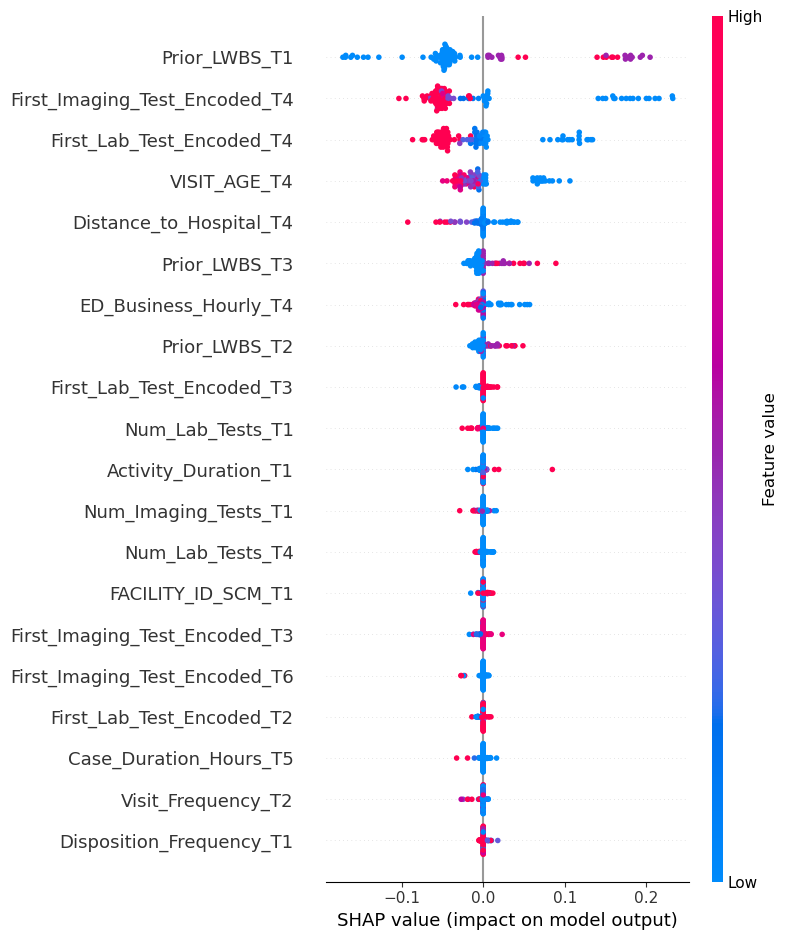

In [38]:
shap.summary_plot(shap_values, subsampleX_test, feature_names=expanded_feature_names)
